In [60]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [61]:
from tensorflow_probability.python.distributions import kl_divergence

In [62]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [63]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [64]:
hf = h5py.File('/mnt/data/HSC/HSC_v6/extra_files/five_band_image127x127_full.hdf5', 'r')

In [65]:
n = 500

In [66]:
x = np.asarray(hf["image"][0:n]).astype('float32')
y = np.asarray(hf["specz"][0:n]).astype('float32')

In [67]:
y = y[:,0]

In [68]:
x.shape

(500, 5, 127, 127)

In [69]:
min_value = np.min(x)
min_value

-42.37785

In [70]:
x = np.transpose(x,(0,2,3,1))
max_value = np.max(x)
min_value = np.min(x)
x_new = np.true_divide(np.subtract(x,min_value),max_value - min_value)

In [71]:
hf.close()

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x_new,y,test_size=0.2)

In [73]:
kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='tanh',input_shape=(120,120,5)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(2,2),activation='tanh'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model.add(Conv2D(32, kernel_size=(2,2),activation='relu'))
model.add(Flatten())
model.add(Dense(500, activation="tanh"))
model.add(Dense(100, activation="tanh"))
model.add(Dense(1))

In [74]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= + 10e-4*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [75]:
model_variational = Sequential([
    tf.keras.Input(shape=(127,127,5),name="basket"),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='tanh', 
                                    kernel_divergence_fn=kl_divergence_function),
    MaxPooling2D(2,2),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='tanh', 
                                    kernel_divergence_fn=kl_divergence_function),
    MaxPooling2D(2,2),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', 
                                    kernel_divergence_fn=kl_divergence_function),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.Flatten(),
    #tfp.layers.DenseVariational(512, activation='tanh', input_shape=(5,), make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(2),
    tfp.layers.IndependentNormal(1)
])

model_variational.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_8 (Conv2DFlip (None, 126, 126, 32)      1312      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_flipout_9 (Conv2DFlip (None, 62, 62, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_flipout_10 (Conv2DFli (None, 30, 30, 32)        8224      
_________________________________________________________________
conv2d_flipout_11 (Conv2DFli (None, 29, 29, 32)        8224      
_________________________________________________________________
flatten_2 (Flatten)          (None, 26912)            

divergence_fn = lambda q,p,_:kl_divergence(q,p)/(n)

model_variational = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape = (120,120,5), filters = 32, kernel_size = (2,2), activation='tanh',
                                           kernel_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (2,2), activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    Conv2D(32, (2,2), activation='relu'),
    Flatten(),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),
    tfpl.DenseReparameterization(2, activation=None, kernel_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), kernel_divergence_fn = divergence_fn, bias_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), bias_divergence_fn = divergence_fn),
    tfp.layers.IndependentNormal(1)
    
])
model_variational.summary()

In [76]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model_variational.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss = negative_loglikelihood, metrics=[keras.metrics.RootMeanSquaredError()])

In [77]:
model_variational.fit(x = x_train, y = y_train, epochs = 300, shuffle = True, verbose=1)

Epoch 1/300
13/13 [==============================] - 2s 14ms/step - loss: 66.3466 - root_mean_squared_error: 6.9181
Epoch 2/300
13/13 [==============================] - 0s 13ms/step - loss: 62.4844 - root_mean_squared_error: 4.7950
Epoch 3/300
13/13 [==============================] - 0s 13ms/step - loss: 58.9559 - root_mean_squared_error: 3.8201
Epoch 4/300
13/13 [==============================] - 0s 13ms/step - loss: 55.7660 - root_mean_squared_error: 3.2749
Epoch 5/300
13/13 [==============================] - 0s 13ms/step - loss: 52.6969 - root_mean_squared_error: 2.9442
Epoch 6/300
13/13 [==============================] - 0s 12ms/step - loss: 49.5177 - root_mean_squared_error: 2.7080
Epoch 7/300
13/13 [==============================] - 0s 12ms/step - loss: 46.4375 - root_mean_squared_error: 2.5304
Epoch 8/300
13/13 [==============================] - 0s 12ms/step - loss: 43.2648 - root_mean_squared_error: 2.3865
Epoch 9/300
13/13 [==============================] - 0s 12ms/step - loss

13/13 [==============================] - 0s 12ms/step - loss: 1.0915 - root_mean_squared_error: 1.3183
Epoch 72/300
13/13 [==============================] - 0s 12ms/step - loss: 1.0958 - root_mean_squared_error: 1.3140
Epoch 73/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1954 - root_mean_squared_error: 1.3116
Epoch 74/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1834 - root_mean_squared_error: 1.3108
Epoch 75/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1908 - root_mean_squared_error: 1.3081
Epoch 76/300
13/13 [==============================] - 0s 12ms/step - loss: 1.2592 - root_mean_squared_error: 1.3058
Epoch 77/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1662 - root_mean_squared_error: 1.3047
Epoch 78/300
13/13 [==============================] - 0s 12ms/step - loss: 1.2504 - root_mean_squared_error: 1.3031
Epoch 79/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1811 - r

13/13 [==============================] - 0s 12ms/step - loss: 1.2606 - root_mean_squared_error: 1.2415
Epoch 142/300
13/13 [==============================] - 0s 12ms/step - loss: 1.2282 - root_mean_squared_error: 1.2428
Epoch 143/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1395 - root_mean_squared_error: 1.2418
Epoch 144/300
13/13 [==============================] - 0s 12ms/step - loss: 1.0465 - root_mean_squared_error: 1.2407
Epoch 145/300
13/13 [==============================] - 0s 12ms/step - loss: 1.0813 - root_mean_squared_error: 1.2390
Epoch 146/300
13/13 [==============================] - 0s 12ms/step - loss: 1.2017 - root_mean_squared_error: 1.2383
Epoch 147/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1504 - root_mean_squared_error: 1.2378
Epoch 148/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1620 - root_mean_squared_error: 1.2364
Epoch 149/300
13/13 [==============================] - 0s 12ms/step - loss: 1.

13/13 [==============================] - 0s 12ms/step - loss: 1.0826 - root_mean_squared_error: 1.2245
Epoch 212/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1450 - root_mean_squared_error: 1.2237
Epoch 213/300
13/13 [==============================] - 0s 12ms/step - loss: 1.0828 - root_mean_squared_error: 1.2228
Epoch 214/300
13/13 [==============================] - 0s 12ms/step - loss: 1.0856 - root_mean_squared_error: 1.2217
Epoch 215/300
13/13 [==============================] - 0s 12ms/step - loss: 1.0818 - root_mean_squared_error: 1.2206
Epoch 216/300
13/13 [==============================] - 0s 12ms/step - loss: 1.4264 - root_mean_squared_error: 1.2206
Epoch 217/300
13/13 [==============================] - 0s 12ms/step - loss: 1.2188 - root_mean_squared_error: 1.2219
Epoch 218/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1911 - root_mean_squared_error: 1.2214
Epoch 219/300
13/13 [==============================] - 0s 12ms/step - loss: 1.

13/13 [==============================] - 0s 12ms/step - loss: 1.3983 - root_mean_squared_error: 1.2155
Epoch 282/300
13/13 [==============================] - 0s 13ms/step - loss: 1.4601 - root_mean_squared_error: 1.2174
Epoch 283/300
13/13 [==============================] - 0s 12ms/step - loss: 2.3232 - root_mean_squared_error: 1.2265
Epoch 284/300
13/13 [==============================] - 0s 13ms/step - loss: 2.1320 - root_mean_squared_error: 1.2511
Epoch 285/300
13/13 [==============================] - 0s 13ms/step - loss: 1.4923 - root_mean_squared_error: 1.2555
Epoch 286/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1977 - root_mean_squared_error: 1.2562
Epoch 287/300
13/13 [==============================] - 0s 13ms/step - loss: 1.1389 - root_mean_squared_error: 1.2555
Epoch 288/300
13/13 [==============================] - 0s 12ms/step - loss: 1.1176 - root_mean_squared_error: 1.2550
Epoch 289/300
13/13 [==============================] - 0s 12ms/step - loss: 1.

In [78]:
model_variational.predict(np.array([x_train[0],x_train[1]]))

array([[ 0.13365287],
       [-0.67293006]], dtype=float32)

In [79]:
model_variational(np.array([x_train[0]])).mean()[0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.5668127>

In [80]:
y_train[0]

2.23359

In [81]:
y_test_prediction = []

for i in range(len(y_test)):
    y_test_prediction.append(model_variational(np.array([x_test[i]])).mean()[0][0])

y_test_prediction = np.asarray(y_test_prediction).astype('float32')

y_test_spectro = np.asarray(y_test)

In [82]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_spectro,y_test_prediction])).astype('float32')
z = gaussian_kde(xy)(xy)

(0.0, 2.0)

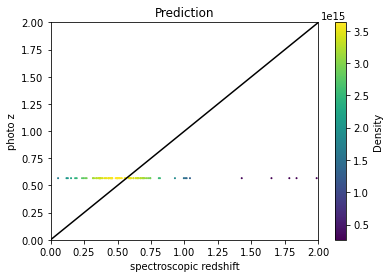

In [83]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_spectro, y_test_prediction, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 2], [0, 2],color = 'black')
plt.xlim([0, 2])
plt.ylim([0, 2])

In [84]:
# END